In [12]:
import pylab
import imageio
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.ndimage.interpolation import geometric_transform
global fps
fps = 20.

from skimage.measure import block_reduce


global origin
global origin_init
global v0,v1,h0,h1

origin_init = (312,220) ## approximate centroid of video frame
origin = origin_init ## to be updated later

In [2]:
train_vid = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/train.mp4'
labels_file = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/train.txt'

In [3]:
## Parse labels file
file = open(labels_file, 'r') 
labels = file.read().split()
file.close()
labels = np.asarray(labels).astype('float32')

Text(0, 0.5, 'car speed (mph)')

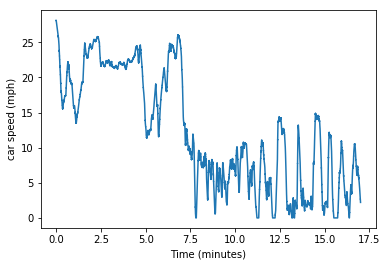

In [4]:
## Plot the training set speeds
t_plot = np.arange(0,len(labels),1)/fps
plt.plot(t_plot/60,labels)
#plt.plot(labels)
plt.xlabel('Time (minutes)')
plt.ylabel('car speed (mph)')

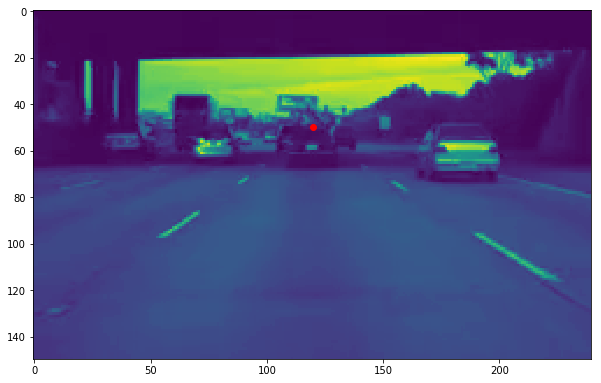

In [5]:
## Try loading a few fraes and mark the origin
vid = imageio.get_reader(train_vid,  'ffmpeg')
nums = range(100)
vid_frames = []
image = vid.get_data(0)
#print(image.shape[0])

v0 = origin_init[0] - 120
v1 = origin_init[0] + 120
h0 = origin_init[1] - 50
h1 = origin_init[1] + 100
origin = (120,50)

for num in nums:
    image = vid.get_data(num)
    vid_frames.append(image[h0:h1,v0:v1])

im = vid_frames[0][:,:,1]
plt.figure(figsize = (10,10))
plt.imshow(im)

plt.plot(origin[0],origin[1],'ro')

## Get the video dimensions
v = vid_frames[0].shape[0]
h = vid_frames[0].shape[1]
#print(v)

## Crude test for speed and checking units based on number of frames to pass a white road line (10 feet)

Time to move 10 feet = 0.15 sec
Estimated speed = 20.32 meters/sec
Claimed speed = 27.37 meters/sec


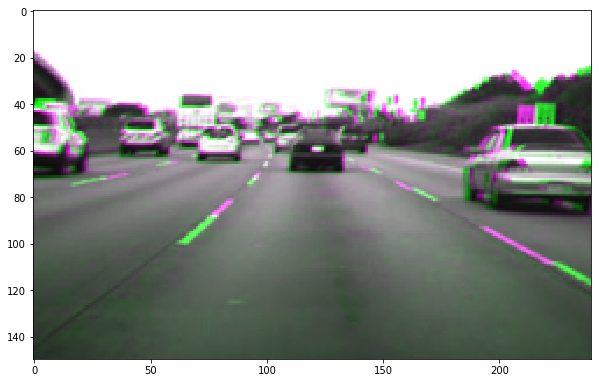

In [6]:
## Test to make sure speeds make sense - do a crude speed estimation
## a white line is 10 feet.
frame1 = 50
frame_diff = 3
V1 = [vid_frames[frame1][:,:,1]]
V1.append(vid_frames[frame1+frame_diff][:,:,1])
V1.append(vid_frames[frame1][:,:,1])
V2 = np.asarray(V1).transpose(1,2,0)
plt.figure(figsize = (10,10))
plt.imshow(V2)

## Note: it looks like the car moves 10 feet in about 3 frames
## Calculate miles per hour (split by lines to make it easy to check)
t_10ft = frame_diff/fps ## Time to move 10 feet = 3 frames / (20 frames/sec)
feet_per_meter = 1./0.3048
dist_moved_meters = 10./feet_per_meter ## 10 f / (ft/meter)
speed = dist_moved_meters/t_10ft

print('Time to move 10 feet = %.2f sec' %t_10ft)
print('Estimated speed = %.2f meters/sec' % speed)
print('Claimed speed = %.2f meters/sec' %(labels[frame1]))

In [7]:
## Borrowed code to augment the training data by adjusting brightness
def brightness_augment(image, offset, rand_amplitude):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    factor = offset + rand_amplitude*np.random.uniform()
    hsv_image[:,:,2] = hsv_image[:,:,2] * factor
    im = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    im = np.round(255.*im/np.max(im)) ## Rescale to min/max of dataset
    return im.astype('uint8')

In [8]:
## More standard code - computes optical flow based on the Farneback method - 
## modified to avoid converting back to rgb
def opticalFlowFarneback_v2(image_current, image_next,win_size = 5):    
    flow_im = np.zeros((image_current.shape[0],image_current.shape[1],2))
    # Flow Parameters
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(image_current, image_next,  
                                        flow_mat, image_scale, 
                                        nb_images, win_size, 
                                        nb_iterations, deg_expansion, 
                                        STD, 0)                                        
        
    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    flow_im[:,:,0] =  ang* (180/ np.pi / 2) #cv2.normalize(ang,None,0,255,cv2.NORM_MINMAX) #ang* (180/ np.pi / 2)
    flow_im[:,:,1] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    flow_im = np.asarray(flow_im, dtype= np.float32)
    return flow_im.astype('uint8')

Compute optic flow (Farneback method) on pairs of frames, and apply same algorithm to compute acceleration. Code modified to include 3 frames instead of 2, which enables the acceleration computation

In [9]:
## Brightness_augment and process
im = 7*3
fr2 = brightness_augment(vidframes_train[im+2],1,0)# 0.5,0.5)
fr1 = brightness_augment(vidframes_train[im+1],1,0)#,0.5,0.5)
fr0 = brightness_augment(vidframes_train[im],1,0)#,0.5,0.5)

fr2 = cv2.cvtColor(fr2, cv2.COLOR_RGB2GRAY)
fr1 = cv2.cvtColor(fr1, cv2.COLOR_RGB2GRAY)
fr0 = cv2.cvtColor(fr0, cv2.COLOR_RGB2GRAY)


flow = opticalFlowFarneback_v2(fr1,fr2,win_size = 2)
flow2  = opticalFlowFarneback_v2(fr1,fr0,win_size = 2)
#acc2 = opticalFlowFarneback_v2(flow[:,:,1], flow2[:,:,1],win_size = 2)

acc = flow2-flow

NameError: name 'vidframes_train' is not defined

NameError: name 'flow' is not defined

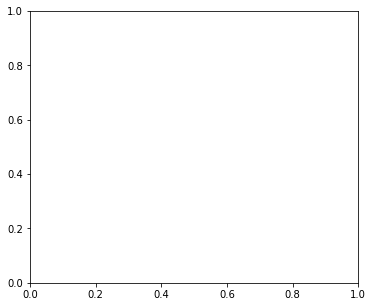

In [10]:
plt.figure(figsize = (20,5))
plt.subplot(131)
plt.imshow(flow[:,:,1]**0.5,cmap = 'hot')
plt.subplot(132)
plt.imshow(abs((fr0-fr1))**0.5,cmap = 'hot')#[:,:,2],cmap = 'gray')
plt.subplot(133)
plt.imshow(acc2[:,:,1],cmap = 'hot')#[:,:,2],cmap = 'gray')

## Section 1a preproc data and concatenate the data into training and dev sets

In [11]:
## Preproc data
def preproc_video_frame(image):
    frA = brightness_augment(image,1,0)
    frB = brightness_augment(image,.5,.5)
    frC = brightness_augment(image,0,1)
    frA = cv2.cvtColor(frA, cv2.COLOR_RGB2GRAY)
    frB = cv2.cvtColor(frB, cv2.COLOR_RGB2GRAY)
    frC = cv2.cvtColor(frC, cv2.COLOR_RGB2GRAY)
    return frA, frB, frC

def get_opflow(fr0, fr1, fr2):
    #raw_diff = (fr1-fr0)**0.5
    dat = np.zeros((fr0.shape[0],fr0.shape[1],3))
    flow = opticalFlowFarneback_v2(fr1,fr2,win_size = 2)
    flow2  = opticalFlowFarneback_v2(fr1,fr0,win_size = 2)
    #dat[:,:,0] = fr1 # Option to remove the angle information#flow[:,:,0]
    dat[:,:,0] = flow[:,:,0] # Option to remove the angle information#

    dat[:,:,1] = flow[:,:,1]**0.5
    acc = flow2-flow
    dat[:,:,2] = acc[:,:,1]
    return dat

import time

(1) Load in video while splitting into train and dev set with 5 sec intervals

In [19]:
np.random.seed(2)
def split_Nsec_intervals(vid_frames, labels, Nsec, maxFrames = None):
    ## Select random sets of n sec: 80% train set, 20% dev set
    
    vid = imageio.get_reader(train_vid,  'ffmpeg')
    
    if maxFrames == None:
        maxFrames = len(labels)
    
    Nframes = int(Nsec*fps)
    L = maxFrames
    L = L-np.mod(L,Nframes)
    i_split = np.random.rand(int(L/Nframes)) 
    A = np.percentile(i_split,80)
    i_split = i_split < A

    
    vidframes_train = []
    vidframes_dev = []
    labels_train = []
    labels_dev = []
    t_train = []
    t_dev = []
    i_save = 0
    i_save_d = 0
    tic = time.time()
    
    for i,ix in enumerate(i_split):
        toc = time.time()-tic
        print('Processing %d of %d   time: %.1f sec'%(i,len(i_split),toc))
        tic = time.time()
        
        ind_frames = np.arange(i*Nframes,(i+1)*Nframes,1)
        
        if ix: ## for train set
                               
            # Initialize 3 diffferent arrays for the different augmented images
            vidframes_train_A = []
            vidframes_train_B = []
            vidframes_train_C = []
                               
            ## initialize prev values at the start of a segment
            image = vid.get_data(ind_frames[0])[h0:h1,v0:v1]
            imApp, imBpp, imCpp = preproc_video_frame(image)
            image = vid.get_data(ind_frames[1])[h0:h1,v0:v1]
            imAp, imBp, imCp = preproc_video_frame(image)

            for fr in ind_frames[2:]:
                image = vid.get_data(fr)[h0:h1,v0:v1]
                imA,imB,imC = preproc_video_frame(image)
                datA = get_opflow(imA, imAp, imApp)
                datB = get_opflow(imB, imBp, imBpp)
                datC = get_opflow(imC, imCp, imCpp)
                                
                vidframes_train_A.append(datA)
                vidframes_train_B.append(datB)
                vidframes_train_C.append(datC)
                
                ## update timesteps from op flow calculations
                imApp, imBpp, imCpp = imAp, imBp, imCp
                imAp, imBp, imCp = imA,imB,imC
        
            ## Save the images to folder called train
            for n in range(len(vidframes_train_A)):
                fle_name = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Train/Im'+str(i_save)+'.png'
                cv2.imwrite(fle_name, vidframes_train_A[n])
                i_save += 1
                
            for n in range(len(vidframes_train_B)):
                fle_name = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Train/Im'+str(i_save)+'.png'
                cv2.imwrite(fle_name, vidframes_train_B[n])
                i_save += 1
                
            for n in range(len(vidframes_train_C)):
                fle_name = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Train/Im'+str(i_save)+'.png'
                cv2.imwrite(fle_name, vidframes_train_C[n])
                i_save += 1
            
            for i in range(3):
                labels_train.append(labels[ind_frames[2:]])
                t_train.append(ind_frames[2:]/fps)
        
        else: ## for dev set
            image = vid.get_data(ind_frames[0])[h0:h1,v0:v1]
            imApp, _, _ = preproc_video_frame(image)
            image = vid.get_data(ind_frames[1])[h0:h1,v0:v1]
            imAp, _, _ = preproc_video_frame(image)
            for fr in ind_frames[2:]:
                image = vid.get_data(fr)[h0:h1,v0:v1]
                imA,_,_ = preproc_video_frame(image)
                datA = get_opflow(imA, imAp, imApp)
    
                fle_name = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Dev/Im'+str(i_save_d)+'.png'
                cv2.imwrite(fle_name, datA)
                i_save_d += 1
        
                ## update timesteps from op flow calculations
                imApp = imAp.copy()
                imAp = imA.copy()
                
            labels_dev.append(labels[ind_frames[2:]])
            t_dev.append(ind_frames[2:]/fps)
            
#            print('Values should be equal: %d %d'%(len(np.asarray(labels_dev).astype('float32').ravel()),i_save_d))
                
    labels_train = np.asarray(labels_train).astype('float32').ravel()
    labels_dev = np.asarray(labels_dev).astype('float32').ravel()
    t_train = np.asarray(t_train).astype('float32').ravel()
    t_dev = np.asarray(t_dev).astype('float32').ravel()
    
    print(i_save)
    print(i_save_d)
    return labels_train,labels_dev,t_train,t_dev

labels_train,labels_dev,t_train,t_dev = split_Nsec_intervals(vid_frames,labels,Nsec = 5)#, maxFrames = 10000)
print('Training labels: %d  Dev labels: %d'%(len(labels_train),len(labels_dev)))
              
with open('/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Labels_dev.txt', 'w') as f:
    for item in labels_dev:
        f.write("%s\n" % item)

with open('/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/T_dev.txt', 'w') as f:
    for item in t_dev:
        f.write("%s\n" % item)
        
with open('/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Labels_train.txt', 'w') as f:
    for item in labels_train:
        f.write("%s\n" % item)

with open('/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/T_train.txt', 'w') as f:
    for item in t_train:
        f.write("%s\n" % item)

Processing 0 of 204   time: 0.0 sec


/home/asya/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


Processing 1 of 204   time: 7.5 sec
Processing 2 of 204   time: 7.4 sec
Processing 3 of 204   time: 7.5 sec
Processing 4 of 204   time: 8.8 sec
Processing 5 of 204   time: 7.9 sec
Processing 6 of 204   time: 7.6 sec
Processing 7 of 204   time: 8.0 sec
Processing 8 of 204   time: 7.4 sec
Processing 9 of 204   time: 7.5 sec
Processing 10 of 204   time: 7.5 sec
Processing 11 of 204   time: 7.9 sec
Processing 12 of 204   time: 9.0 sec
Processing 13 of 204   time: 8.2 sec
Processing 14 of 204   time: 8.4 sec
Processing 15 of 204   time: 7.9 sec
Processing 16 of 204   time: 3.2 sec
Processing 17 of 204   time: 3.3 sec
Processing 18 of 204   time: 8.1 sec
Processing 19 of 204   time: 3.5 sec
Processing 20 of 204   time: 8.4 sec
Processing 21 of 204   time: 7.7 sec
Processing 22 of 204   time: 8.1 sec
Processing 23 of 204   time: 7.9 sec
Processing 24 of 204   time: 7.7 sec
Processing 25 of 204   time: 7.4 sec
Processing 26 of 204   time: 7.6 sec
Processing 27 of 204   time: 8.0 sec
Processing

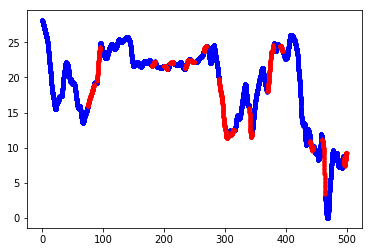

In [379]:
## Visualise speeds in the training and dev sets
plt.figure()
plt.plot(t_train,labels_train,'b.')
plt.plot(t_dev,labels_dev,'r.')

In [18]:
## Preproc data

def opticalFlowFarneback(image_current, image_next,win_size = 5):    
    flow_im = np.zeros((image_current.shape[0],image_current.shape[1],2))
    # Flow Parameters
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(image_current, image_next,  
                                        flow_mat, image_scale, 
                                        nb_images, win_size, 
                                        nb_iterations, deg_expansion, 
                                        STD, 0)                                        
        
    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    flow_im[:,:,0] =  ang* (180/ np.pi / 2) #cv2.normalize(ang,None,0,255,cv2.NORM_MINMAX) #ang* (180/ np.pi / 2)
    flow_im[:,:,1] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    flow_im = np.asarray(flow_im, dtype= np.float32)
    return flow_im.astype('uint8')

def bw_video_frame(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image

def get_opflow(fr0, fr1, fr2):
    #raw_diff = (fr1-fr0)**0.5
    dat = np.zeros((fr0.shape[0],fr0.shape[1],3))
    flow = opticalFlowFarneback(fr1,fr2,win_size = 2)
    flow2  = opticalFlowFarneback(fr1,fr0,win_size = 2)
    #dat[:,:,0] = fr1 # Option to remove the angle information#flow[:,:,0]
    dat[:,:,0] = flow[:,:,0] # Option to remove the angle information#

    dat[:,:,1] = flow[:,:,1]**0.5
    acc = flow2-flow
    dat[:,:,2] = acc[:,:,1]
    return dat

np.random.seed(2)
def preproc_and_save_im(vid, path,fr, i_save, imAp, imApp):
    image = vid.get_data(fr)[h0:h1,v0:v1]
    imA = bw_video_frame(image)
    datA = get_opflow(imA, imAp, imApp)     
    #datA = block_reduce(datA, block_size=(3, 3, 1), func=np.median)
                
    fle_name = path+'Im'+str(i_save)+'.png'
    cv2.imwrite(fle_name, datA)
    
def preproc_test_vid():    
    
    test_vid = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/test.mp4'
    vid = imageio.get_reader(test_vid,  'ffmpeg')
    
    test_path = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Test/'
    
    maxFrames = 10798

    vidframes_test = []
    i_save = 0
    
    image = vid.get_data(0)[h0:h1,v0:v1]
    imApp = bw_video_frame(image)
    image = vid.get_data(1)[h0:h1,v0:v1]
    imAp = bw_video_frame(image)
    
    ## Extend image 2 into frames 0 and 2
    image = vid.get_data(2)[h0:h1,v0:v1]
    imA = bw_video_frame(image)
    datA = get_opflow(imA, imAp, imApp)     
    
  #  datA = block_reduce(datA, block_size=(5, 5, 1), func=np.max)
    
    fle_name = test_path+'/Im'+str(i_save)+'.png'
    cv2.imwrite(fle_name, datA)
    i_save += 1
    fle_name = test_path+'/Im'+str(i_save)+'.png'
    cv2.imwrite(fle_name, datA)
    i_save += 1
            
    tic = time.time()
    
    for fr in np.arange(2,maxFrames,1):
        preproc_and_save_im(vid, test_path ,fr, i_save, imAp, imApp)

        i_save += 1
        
        ## update timesteps from op flow calculations
        imApp = imAp.copy()
        imAp = imA.copy()
        
        if np.mod(fr,1000)==0:
            t = time.time()-tic
            print('Processed %d of %d Step time %.2f sec'%(fr,maxFrames,t))
            tic = time.time()

preproc_test_vid()

Processed 1000 of 10798 Step time 22.72 sec
Processed 2000 of 10798 Step time 22.28 sec
Processed 3000 of 10798 Step time 22.01 sec
Processed 4000 of 10798 Step time 22.10 sec
Processed 5000 of 10798 Step time 22.10 sec
Processed 6000 of 10798 Step time 22.30 sec
Processed 7000 of 10798 Step time 22.38 sec
Processed 8000 of 10798 Step time 22.37 sec
Processed 9000 of 10798 Step time 22.47 sec
Processed 10000 of 10798 Step time 22.09 sec
